## Sentiment Analysis of discussion-dominating Items
Gulliver Wutz

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
pd.set_option('display.max_colwidth', 500)

In [2]:
reddit_posts = pd.read_csv('C:/Users/wutzg/Desktop/Master Thesis/Artifacts/Datasets/reddit_posts_sentiment_2.csv')
reddit_posts.columns

Index(['Subreddit', 'Title', 'ID', 'Full ID', 'Author', 'URL', 'Is Self-post',
       'Score', 'Comment Count', 'Created CEST', 'Collected CEST',
       'Updated CEST', 'Content', 'Patch', 'BERT-BASE Title Sentiment',
       'BERT-BASE Content Sentiment', 'RoBERTa Title Sentiment',
       'RoBERTa Content Sentiment'],
      dtype='object')

In [3]:
with open('item_dictionary.json', 'r') as file:
    item_dict = json.load(file)

In [4]:
post_contents_df = reddit_posts[(reddit_posts['Patch'] != 0) & (reddit_posts['Is Self-post'] == True)].copy()
post_contents_df.loc[:, 'Full Content'] = post_contents_df['Title'] + ' ' + post_contents_df['Content']
post_contents_df = post_contents_df.dropna()

In [5]:
all_aliases = sum(item_dict.values(), [])
all_aliases = [' ' + word + ' ' for word in all_aliases]
all_aliases = [alias.lower() for alias in all_aliases]

def find_word_in_text(text, words):
    for word in words:
        if word in text:
            return word
    return "NO ALIAS"

post_contents_df['Alias'] = post_contents_df['Full Content'].apply(lambda x: find_word_in_text(x, all_aliases))

In [6]:
post_contents_df = post_contents_df[post_contents_df['Alias'] != 'NO ALIAS']

flat_alias_dict = {alias: name for name, aliases in item_dict.items() for alias in aliases}
flat_alias_dict = {key.lower(): value for key, value in flat_alias_dict.items()}
flat_alias_dict = {' ' + key + ' ': value for key, value in flat_alias_dict.items()}
post_contents_df['Item'] = post_contents_df['Alias'].map(flat_alias_dict)
post_contents_df['Item'].fillna('Unknown Item', inplace=True)
post_contents_df.columns

Index(['Subreddit', 'Title', 'ID', 'Full ID', 'Author', 'URL', 'Is Self-post',
       'Score', 'Comment Count', 'Created CEST', 'Collected CEST',
       'Updated CEST', 'Content', 'Patch', 'BERT-BASE Title Sentiment',
       'BERT-BASE Content Sentiment', 'RoBERTa Title Sentiment',
       'RoBERTa Content Sentiment', 'Full Content', 'Alias', 'Item'],
      dtype='object')

In [7]:
terms_count = post_contents_df.groupby('Item').agg({'Score': 'mean',
                                                     'BERT-BASE Title Sentiment': 'mean',
                                                     'RoBERTa Title Sentiment': 'mean',
                                                     'BERT-BASE Content Sentiment': 'mean',
                                                     'RoBERTa Content Sentiment': 'mean',
                                                     'Comment Count': 'mean',
                                                     'ID': 'size'}).reset_index()
terms_count = terms_count.rename(columns={'ID': 'Number of Appearances'})
terms_count = terms_count[terms_count['Item'] != 'Unknown Item']
terms_count

,Item,Score,BERT-BASE Title Sentiment,RoBERTa Title Sentiment,BERT-BASE Content Sentiment,RoBERTa Content Sentiment,Comment Count,Number of Appearances
0,Abyssal Mask,9.800000,2.133333,0.933333,1.933333,1.200000,9.133333,15
1,Aether Wisp,8.000000,2.333333,1.000000,2.333333,1.000000,5.666667,3
2,Amplifying Tome,14.500000,2.500000,1.125000,2.250000,1.625000,9.125000,8
3,Archangels Staff,6.000000,2.250000,0.750000,1.916667,1.000000,10.583333,12
4,Ardent Censer,30.400000,2.560000,0.920000,1.920000,1.240000,16.240000,25
...,...,...,...,...,...,...,...,...
173,Youmuus Ghostblade,8.076923,1.769231,0.923077,1.846154,1.000000,6.076923,13
174,Zaz'Zak's Realmspike,7.333333,2.333333,1.000000,2.666667,1.000000,12.000000,3
175,Zeal,9.041667,2.291667,1.041667,1.875000,0.916667,11.666667,24
176,Zephyr,0.000000,1.000000,1.000000,3.000000,2.000000,2.000000,1


#### Top and Bottom Items by 'Number of Appearances'

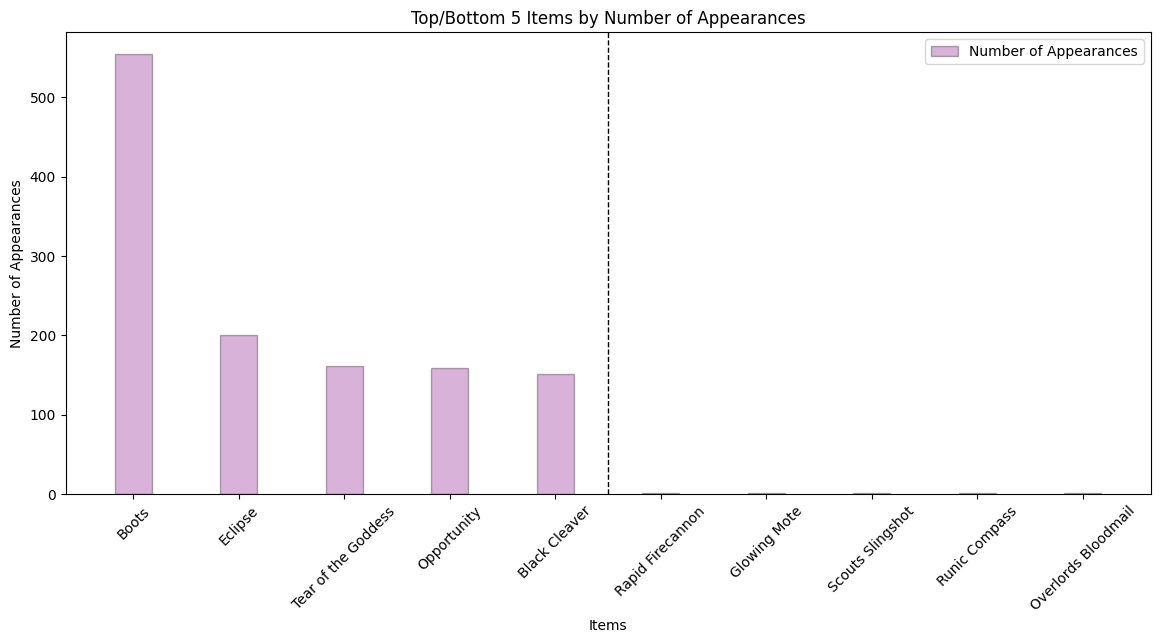

In [8]:
plot_df = terms_count
plot_df = plot_df[plot_df['Number of Appearances'] != 0]
plot_df.sort_values(by='Number of Appearances', ascending=False, inplace=True)
plot_df.reset_index(drop=True, inplace=True)
first_5 = plot_df.iloc[:5]
last_5 = plot_df.iloc[-5:]
plot_df = pd.concat([first_5, last_5])
plot_df.reset_index(drop=True, inplace=True)

# Plotting
bar_width = 0.35

# Set the position of the bars on the x-axis
r1 = np.arange(len(plot_df['Item']))+0.175

# Make the plot
plt.figure(figsize=(14, 6))
plt.bar(r1, plot_df['Number of Appearances'], color='purple', alpha=0.3, width=bar_width, edgecolor='black', label='Number of Appearances')


# Add a vertical dashed red line in the center of the plot
center_position = len(plot_df['Item']) / 2 - 0.325
plt.axvline(x=center_position, color='black', linestyle='--', linewidth=1)

# Add xticks on the middle of the group bars
plt.xlabel('Items')
plt.xticks([r + bar_width / 2 for r in range(len(plot_df['Item']))], plot_df['Item'])
plt.xticks(rotation=45)
# plt.yticks([])

# Add labels and title
plt.ylabel('Number of Appearances')
plt.title('Top/Bottom 5 Items by Number of Appearances')

# Create Legend
plt.legend()
plt.show()

#### Top and Bottom Items by 'Score Rank'

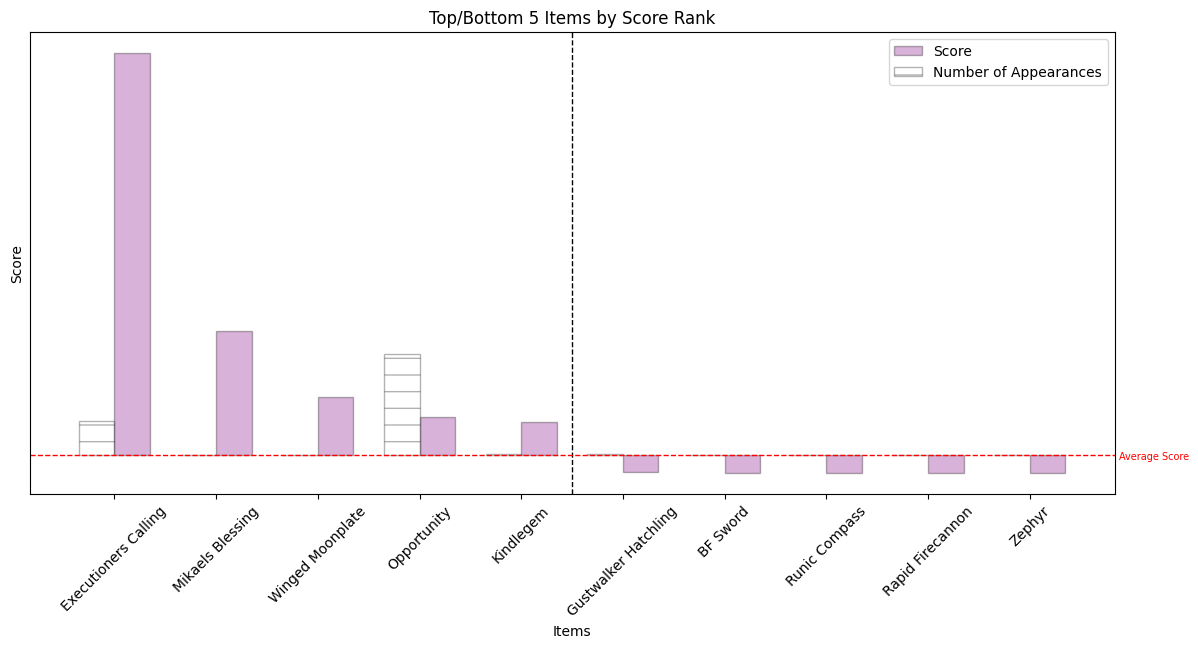

In [9]:
columns_to_normalize = ['Score', 'BERT-BASE Title Sentiment', 'RoBERTa Title Sentiment', 'BERT-BASE Content Sentiment', 'RoBERTa Content Sentiment', 
                        'Comment Count', 'Number of Appearances']
columns_to_offset = ['Number of Appearances']

terms_count[columns_to_normalize] = terms_count[columns_to_normalize].apply(lambda x: (x - x.mean()) / x.std())
terms_count[columns_to_offset] = terms_count[columns_to_offset].apply(lambda x: x - x.min())
terms_count['Score Rank'] = terms_count['Score'] * terms_count['Number of Appearances']
terms_count['Comment Rank'] = terms_count['Comment Count'] * terms_count['Number of Appearances']
terms_count['Sentiment Rank'] = ((terms_count['BERT-BASE Title Sentiment'] + terms_count['RoBERTa Title Sentiment'] + terms_count['BERT-BASE Content Sentiment'] + terms_count['RoBERTa Content Sentiment']) / 4) * terms_count['Number of Appearances']

plot_df = terms_count
plot_df.sort_values(by='Score', ascending=False, inplace=True)
plot_df.reset_index(drop=True, inplace=True)
first_5 = plot_df.iloc[:5]
last_5 = plot_df.iloc[-5:]
plot_df = pd.concat([first_5, last_5])
plot_df.reset_index(drop=True, inplace=True)


# Plotting
bar_width = 0.35

# Set the position of the bars on the x-axis
r1 = np.arange(len(plot_df['Item']))
r2 = [x + bar_width for x in r1]

# Make the plot
plt.figure(figsize=(14, 6))
plt.bar(r2, plot_df['Score'], color='purple', alpha=0.3, width=bar_width, edgecolor='black', label='Score')
plt.bar(r1, plot_df['Number of Appearances'], color='white', alpha=0.3, width=bar_width, edgecolor='black', hatch='-', label='Number of Appearances')


# Add a vertical dashed red line in the center of the plot
center_position = len(plot_df['Item']) / 2 - 0.325  # Adjust for zero-indexing
plt.axvline(x=center_position, color='black', linestyle='--', linewidth=1)

# Add a dashed horizontal red line at y=0 across the entire plot
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.text(len(plot_df['Item']) + 0.05, -0.2, 'Average Score', color='red', fontsize=7, verticalalignment='bottom')

# Add xticks on the middle of the group bars
plt.xlabel('Items')
plt.xticks([r + bar_width / 2 for r in range(len(plot_df['Item']))], plot_df['Item'])
plt.xticks(rotation=45)
plt.yticks([])

# Add labels and title
plt.ylabel('Score')
plt.title('Top/Bottom 5 Items by Score Rank')

# Create legend & Show graphic
plt.legend()
plt.show()

#### Top and Bottom Items by 'Comment Rank'

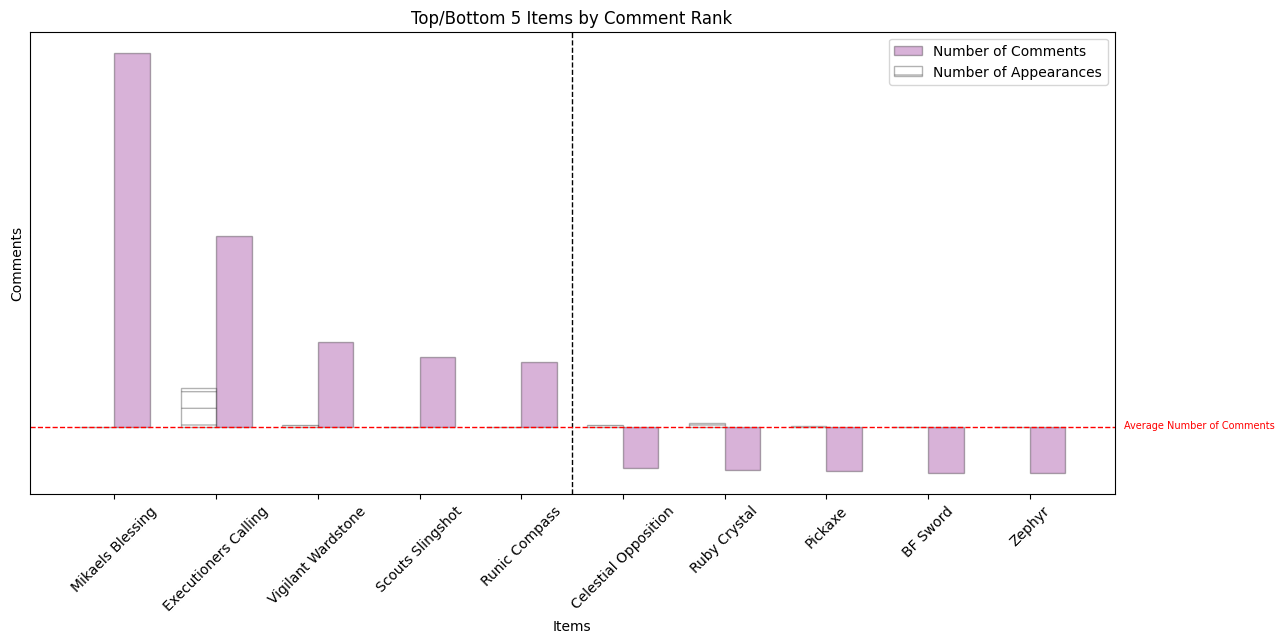

In [10]:
plot_df = terms_count
plot_df.sort_values(by='Comment Count', ascending=False, inplace=True)
plot_df.reset_index(drop=True, inplace=True)
first_5 = plot_df.iloc[:5]
last_5 = plot_df.iloc[-5:]
plot_df = pd.concat([first_5, last_5])
plot_df.reset_index(drop=True, inplace=True)


# Plotting
bar_width = 0.35

# Set the position of the bars on the x-axis
r1 = np.arange(len(plot_df['Item']))
r2 = [x + bar_width for x in r1]

# Make the plot
plt.figure(figsize=(14, 6))
plt.bar(r2, plot_df['Comment Count'], color='purple', alpha=0.3, width=bar_width, edgecolor='black', label='Number of Comments')
plt.bar(r1, plot_df['Number of Appearances'], color='white', alpha=0.3, width=bar_width, edgecolor='black', hatch='-', label='Number of Appearances')


# Add a vertical dashed red line in the center of the plot
center_position = len(plot_df['Item']) / 2 - 0.325  # Adjust for zero-indexing
plt.axvline(x=center_position, color='black', linestyle='--', linewidth=1)

# Add a dashed horizontal red line at y=0 across the entire plot
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.text(len(plot_df['Item']) + 0.1, -0.085, 'Average Number of Comments', color='red', fontsize=7, verticalalignment='bottom')

# Add xticks on the middle of the group bars
plt.xlabel('Items')
plt.xticks([r + bar_width / 2 for r in range(len(plot_df['Item']))], plot_df['Item'])
plt.xticks(rotation=45)
plt.yticks([])

# Add labels and title
plt.ylabel('Comments')
plt.title('Top/Bottom 5 Items by Comment Rank')

# Create legend & Show graphic
plt.legend()
plt.show()

#### Top and Bottom Items by 'Sentiment Rank'

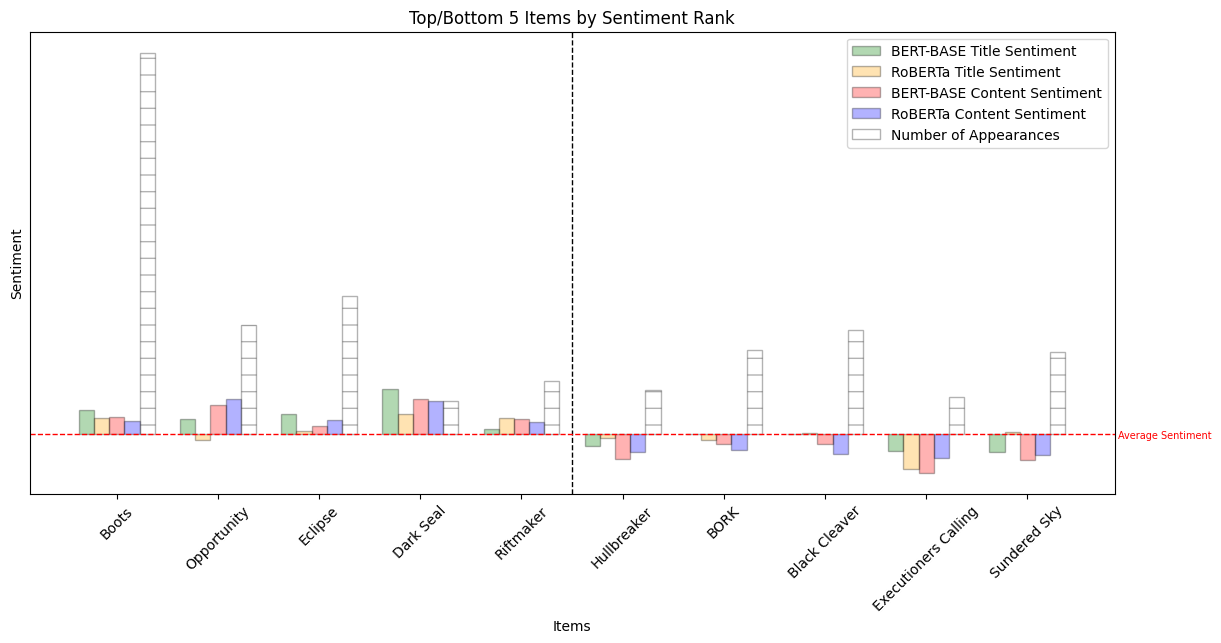

In [11]:
plot_df = terms_count
plot_df.sort_values(by='Sentiment Rank', ascending=False, inplace=True)
plot_df.reset_index(drop=True, inplace=True)
first_5 = plot_df.iloc[:5]
last_5 = plot_df.iloc[-5:]
plot_df = pd.concat([first_5, last_5])
plot_df.reset_index(drop=True, inplace=True)


# Plotting
bar_width = 0.15

# Position of bars on x-axis
r1 = np.arange(len(plot_df['Item']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]

# Make the plot
plt.figure(figsize=(14, 6))  # Adjusting the figure size to fit all bars
plt.bar(r1, plot_df['BERT-BASE Title Sentiment'], color='green', alpha=0.3, width=bar_width, edgecolor='black', label='BERT-BASE Title Sentiment')
plt.bar(r2, plot_df['RoBERTa Title Sentiment'], color='orange', alpha=0.3, width=bar_width, edgecolor='black', label='RoBERTa Title Sentiment')
plt.bar(r3, plot_df['BERT-BASE Content Sentiment'], color='red', alpha=0.3, width=bar_width, edgecolor='black', label='BERT-BASE Content Sentiment')
plt.bar(r4, plot_df['RoBERTa Content Sentiment'], color='blue', alpha=0.3, width=bar_width, edgecolor='black', label='RoBERTa Content Sentiment')
plt.bar(r5, plot_df['Number of Appearances'], color='white', alpha=0.3, width=bar_width, edgecolor='black', hatch='-', label='Number of Appearances')

# Add a vertical dashed red line in the center of the plot
center_position = len(plot_df['Item']) / 2 - 0.2
plt.axvline(x=center_position, color='black', linestyle='--', linewidth=1)

# Add a dashed horizontal red line at y=0 across the entire plot
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.text(len(plot_df['Item']) + 0.2, -0.18, 'Average Sentiment', color='red', fontsize=7, verticalalignment='bottom')

# Add xticks on the middle of the group bars
plt.xlabel('Items')
plt.xticks([r + 2 * bar_width for r in range(len(plot_df['Item']))], plot_df['Item'])
plt.xticks(rotation=45)
plt.yticks([])

# Add labels and title
plt.ylabel('Sentiment')
plt.title('Top/Bottom 5 Items by Sentiment Rank')


# Create legend & Show graphic
plt.legend()
plt.show()

#### Top 5 by 'Appearance Volatility'

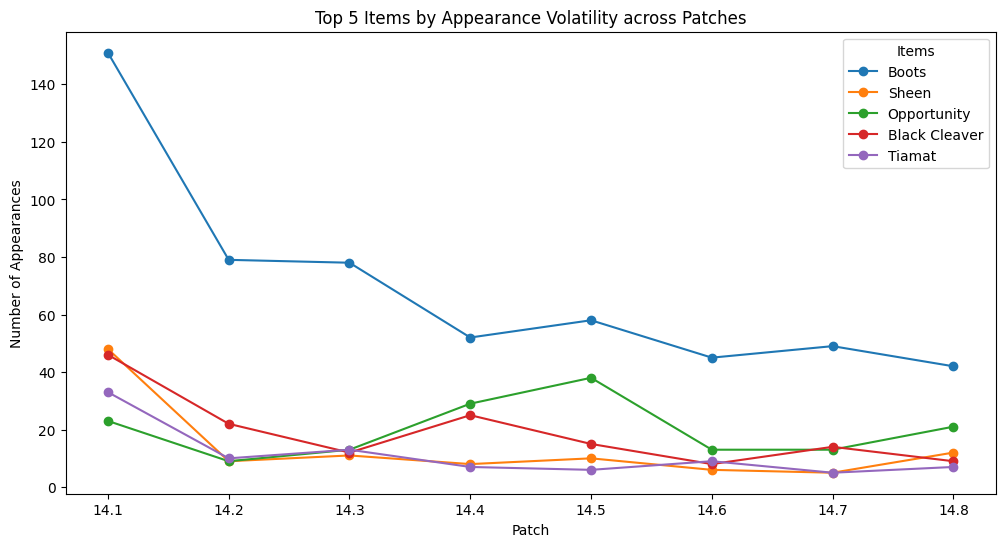

In [12]:
term_patch_values_df = post_contents_df.groupby(['Item', 'Patch']).agg(
    Score=('Score', 'mean'),
    Number_of_Posts=('ID', 'size')
).reset_index()
term_patch_values_df['Avg_Score'] = term_patch_values_df['Score']
term_patch_values_df = term_patch_values_df[term_patch_values_df['Item'] != 'Unknown Item']
term_patch_values_df

term_patch_values_df['diffs'] = term_patch_values_df['Number_of_Posts'].diff()
mask = term_patch_values_df.Item != term_patch_values_df.Item.shift(1)
term_patch_values_df.loc[mask, 'diffs'] = np.nan
term_patch_values_df['diffs'] = term_patch_values_df['diffs'].fillna(0)
term_patch_values_df['diffs_squared'] = term_patch_values_df['diffs'] ** 2

# Normalize
columns_to_normalize = ['diffs_squared']
term_patch_values_df[columns_to_normalize] = term_patch_values_df[columns_to_normalize].apply(lambda x: (x - x.mean()) / x.std())
term_patch_values_df

volatility_df = term_patch_values_df.groupby(['Item']).agg(
    diffs_squared=('diffs_squared', 'mean'),
    Number_of_Posts=('Number_of_Posts', 'sum')
).reset_index()
volatility_df['volatility_rank'] = volatility_df['diffs_squared']
volatility_df.sort_values(by='volatility_rank', ascending=False, inplace=True)
volatility_df.reset_index(drop=True, inplace=True)
volatility_df = volatility_df.iloc[:5]
volatility_df.reset_index(drop=True, inplace=True)
volatility_df

plot_df = term_patch_values_df[term_patch_values_df['Item'].isin(volatility_df['Item'])]
plot_df = plot_df.merge(volatility_df[['Item', 'volatility_rank']], on='Item', how='left')
plot_df.sort_values(by=['volatility_rank', 'Patch'], ascending=False, inplace=True)
plot_df

# Plotting
plt.figure(figsize=(12, 6))

for subreddit in plot_df['Item'].unique():
    subset = plot_df[plot_df['Item'] == subreddit]
    plt.plot(subset['Patch'], subset['Number_of_Posts'], marker='o', label=subreddit)

plt.title('Top 5 Items by Appearance Volatility across Patches')
plt.xlabel('Patch')
plt.ylabel('Number of Appearances')
# plt.yticks([])
plt.legend(title='Items')
plt.grid(False)
plt.show()

#### Bottom 5 by 'Appearance Volatility'

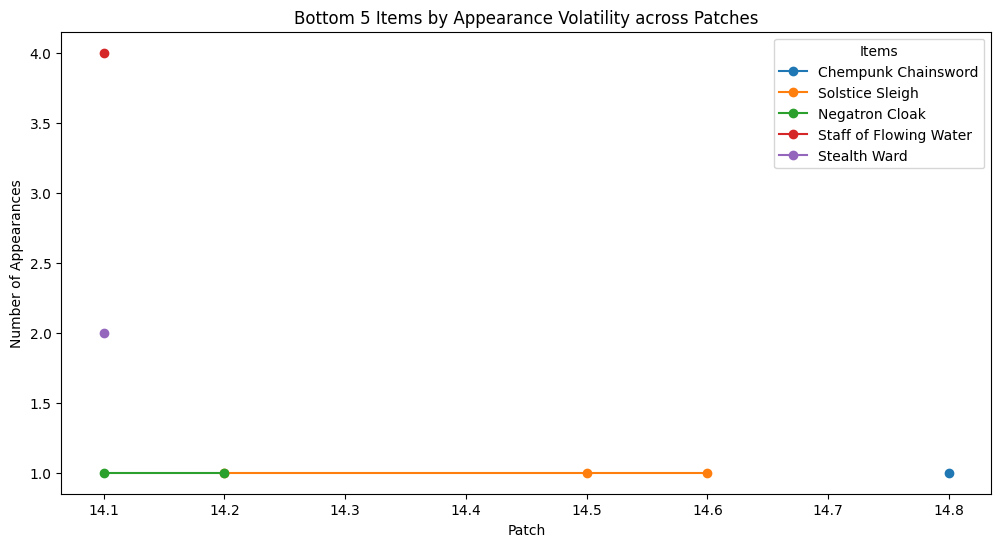

In [16]:
term_patch_values_df = post_contents_df.groupby(['Item', 'Patch']).agg(
    Score=('Score', 'mean'),
    Number_of_Posts=('ID', 'size')
).reset_index()
term_patch_values_df['Avg_Score'] = term_patch_values_df['Score']
term_patch_values_df = term_patch_values_df[term_patch_values_df['Item'] != 'Unknown Item']
term_patch_values_df

term_patch_values_df['diffs'] = term_patch_values_df['Number_of_Posts'].diff()
mask = term_patch_values_df.Item != term_patch_values_df.Item.shift(1)
term_patch_values_df.loc[mask, 'diffs'] = np.nan
term_patch_values_df['diffs'] = term_patch_values_df['diffs'].fillna(0)
term_patch_values_df['diffs_squared'] = term_patch_values_df['diffs'] ** 2

# Normalize
columns_to_normalize = ['diffs_squared']
term_patch_values_df[columns_to_normalize] = term_patch_values_df[columns_to_normalize].apply(lambda x: (x - x.mean()) / x.std())
term_patch_values_df

volatility_df = term_patch_values_df.groupby(['Item']).agg(
    diffs_squared=('diffs_squared', 'mean'),
    Number_of_Posts=('Number_of_Posts', 'sum')
).reset_index()
volatility_df['volatility_rank'] = volatility_df['diffs_squared']
volatility_df.sort_values(by='volatility_rank', ascending=False, inplace=True)
volatility_df.reset_index(drop=True, inplace=True)
volatility_df = volatility_df.iloc[-5:]
volatility_df.reset_index(drop=True, inplace=True)
volatility_df

plot_df = term_patch_values_df[term_patch_values_df['Item'].isin(volatility_df['Item'])]
plot_df = plot_df.merge(volatility_df[['Item', 'volatility_rank']], on='Item', how='left')
plot_df.sort_values(by=['volatility_rank', 'Patch'], ascending=False, inplace=True)
plot_df

# Plotting
plt.figure(figsize=(12, 6))

for subreddit in plot_df['Item'].unique():
    subset = plot_df[plot_df['Item'] == subreddit]
    plt.plot(subset['Patch'], subset['Number_of_Posts'], marker='o', label=subreddit)

plt.title('Bottom 5 Items by Appearance Volatility across Patches')
plt.xlabel('Patch')
plt.ylabel('Number of Appearances')
# plt.yticks([])
plt.legend(title='Items')
plt.grid(False)
plt.show()

#### Top 5 by 'Score Volatility Rank'

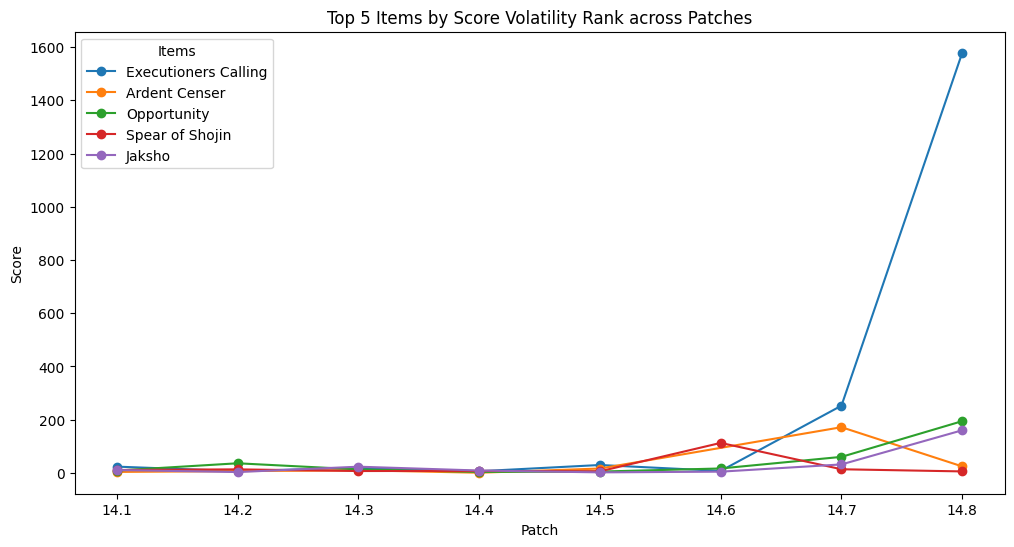

In [14]:
term_patch_values_df = post_contents_df.groupby(['Item', 'Patch']).agg(
    Score=('Score', 'mean'),
    Number_of_Posts=('ID', 'size')
).reset_index()
term_patch_values_df['Avg_Score'] = term_patch_values_df['Score']
term_patch_values_df = term_patch_values_df[term_patch_values_df['Item'] != 'Unknown Item']

term_patch_values_df['diffs'] = term_patch_values_df['Avg_Score'].diff()
mask = term_patch_values_df.Item != term_patch_values_df.Item.shift(1)
term_patch_values_df.loc[mask, 'diffs'] = np.nan
term_patch_values_df['diffs'] = term_patch_values_df['diffs'].fillna(0)
term_patch_values_df['diffs_squared'] = term_patch_values_df['diffs'] ** 2

# Normalize
columns_to_normalize = ['diffs_squared']
term_patch_values_df[columns_to_normalize] = term_patch_values_df[columns_to_normalize].apply(lambda x: (x - x.mean()) / x.std())

volatility_df = term_patch_values_df.groupby(['Item']).agg(
    diffs_squared=('diffs_squared', 'mean'),
    Number_of_Posts=('Number_of_Posts', 'sum')
).reset_index()
volatility_df['volatility_rank'] = volatility_df['diffs_squared'] * volatility_df['Number_of_Posts']
volatility_df.sort_values(by='volatility_rank', ascending=False, inplace=True)
volatility_df.reset_index(drop=True, inplace=True)
volatility_df = volatility_df.iloc[:5]
volatility_df.reset_index(drop=True, inplace=True)
volatility_df

plot_df = term_patch_values_df[term_patch_values_df['Item'].isin(volatility_df['Item'])]
plot_df = plot_df.merge(volatility_df[['Item', 'volatility_rank']], on='Item', how='left')
plot_df.sort_values(by=['volatility_rank', 'Patch'], ascending=False, inplace=True)

# Plotting
plt.figure(figsize=(12, 6))

for subreddit in plot_df['Item'].unique():
    subset = plot_df[plot_df['Item'] == subreddit]
    plt.plot(subset['Patch'], subset['Avg_Score'], marker='o', label=subreddit)

plt.title('Top 5 Items by Score Volatility Rank across Patches')
plt.xlabel('Patch')
plt.ylabel('Score')
# plt.yticks([])
plt.legend(title='Items')
plt.grid(False)
plt.show()

#### Bottom 5 by 'Score Volatility Rank'

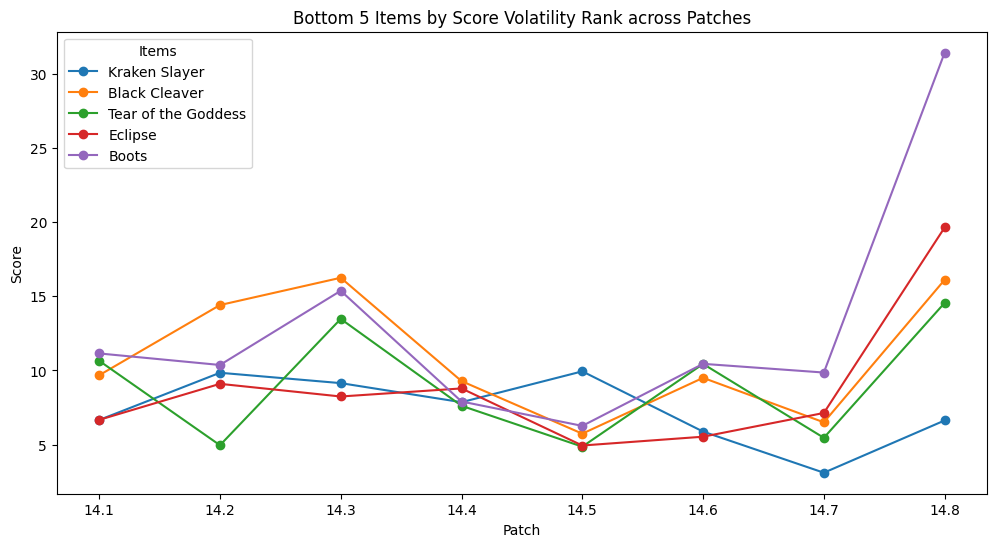

In [17]:
term_patch_values_df = post_contents_df.groupby(['Item', 'Patch']).agg(
    Score=('Score', 'mean'),
    Number_of_Posts=('ID', 'size')
).reset_index()
term_patch_values_df['Avg_Score'] = term_patch_values_df['Score']
term_patch_values_df = term_patch_values_df[term_patch_values_df['Item'] != 'Unknown Item']

term_patch_values_df['diffs'] = term_patch_values_df['Avg_Score'].diff()
mask = term_patch_values_df.Item != term_patch_values_df.Item.shift(1)
term_patch_values_df.loc[mask, 'diffs'] = np.nan
term_patch_values_df['diffs'] = term_patch_values_df['diffs'].fillna(0)
term_patch_values_df['diffs_squared'] = term_patch_values_df['diffs'] ** 2

# Normalize
columns_to_normalize = ['diffs_squared']
term_patch_values_df[columns_to_normalize] = term_patch_values_df[columns_to_normalize].apply(lambda x: (x - x.mean()) / x.std())

volatility_df = term_patch_values_df.groupby(['Item']).agg(
    diffs_squared=('diffs_squared', 'mean'),
    Number_of_Posts=('Number_of_Posts', 'sum')
).reset_index()
volatility_df['volatility_rank'] = volatility_df['diffs_squared'] * volatility_df['Number_of_Posts']
volatility_df.sort_values(by='volatility_rank', ascending=False, inplace=True)
volatility_df.reset_index(drop=True, inplace=True)
volatility_df = volatility_df.iloc[-5:]
volatility_df.reset_index(drop=True, inplace=True)
volatility_df

plot_df = term_patch_values_df[term_patch_values_df['Item'].isin(volatility_df['Item'])]
plot_df = plot_df.merge(volatility_df[['Item', 'volatility_rank']], on='Item', how='left')
plot_df.sort_values(by=['volatility_rank', 'Patch'], ascending=False, inplace=True)

# Plotting
plt.figure(figsize=(12, 6))

for subreddit in plot_df['Item'].unique():
    subset = plot_df[plot_df['Item'] == subreddit]
    plt.plot(subset['Patch'], subset['Avg_Score'], marker='o', label=subreddit)

plt.title('Bottom 5 Items by Score Volatility Rank across Patches')
plt.xlabel('Patch')
plt.ylabel('Score')
# plt.yticks([])
plt.legend(title='Items')
plt.grid(False)
plt.show()

#### Top 5 by 'Sentiment Volatility Rank'

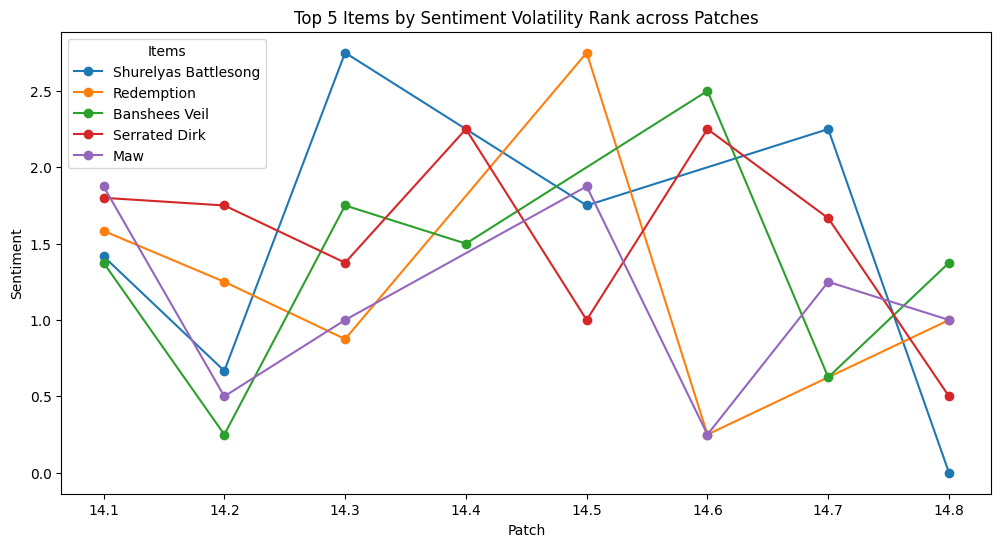

In [15]:
term_patch_values_df = post_contents_df.groupby(['Item', 'Patch']).agg(
    Score=('Score', 'mean'),
    BERT_BASE_Title_Sentiment=('BERT-BASE Title Sentiment', 'mean'),
    RoBERTa_Title_Sentiment=('RoBERTa Title Sentiment', 'mean'),
    BERT_BASE_Content_Sentiment=('BERT-BASE Content Sentiment', 'mean'),
    RoBERTa_Content_Sentiment=('RoBERTa Content Sentiment', 'mean'),
    Number_of_Posts=('ID', 'size')
).reset_index()
term_patch_values_df['Avg_Sentiment'] = (term_patch_values_df['BERT_BASE_Title_Sentiment'] + term_patch_values_df['RoBERTa_Title_Sentiment'] + term_patch_values_df['BERT_BASE_Content_Sentiment'] + term_patch_values_df['RoBERTa_Content_Sentiment']) / 4
term_patch_values_df = term_patch_values_df[term_patch_values_df['Item'] != 'Unknown Item']

term_patch_values_df['diffs'] = term_patch_values_df['Avg_Sentiment'].diff()
mask = term_patch_values_df.Item != term_patch_values_df.Item.shift(1)
term_patch_values_df.loc[mask, 'diffs'] = np.nan
term_patch_values_df['diffs'] = term_patch_values_df['diffs'].fillna(0)
term_patch_values_df['diffs_squared'] = term_patch_values_df['diffs'] ** 2

# Normalize
columns_to_normalize = ['diffs_squared']
term_patch_values_df[columns_to_normalize] = term_patch_values_df[columns_to_normalize].apply(lambda x: (x - x.mean()) / x.std())

volatility_df = term_patch_values_df.groupby(['Item']).agg(
    diffs_squared=('diffs_squared', 'mean'),
    Number_of_Posts=('Number_of_Posts', 'sum')
).reset_index()
volatility_df['volatility_rank'] = volatility_df['diffs_squared'] * volatility_df['Number_of_Posts']
volatility_df.sort_values(by='volatility_rank', ascending=False, inplace=True)
volatility_df.reset_index(drop=True, inplace=True)
volatility_df = volatility_df.iloc[:5]
volatility_df.reset_index(drop=True, inplace=True)

plot_df = term_patch_values_df[term_patch_values_df['Item'].isin(volatility_df['Item'])]
plot_df = plot_df.merge(volatility_df[['Item', 'volatility_rank']], on='Item', how='left')
plot_df.sort_values(by=['volatility_rank', 'Patch'], ascending=False, inplace=True)

# Plotting
plt.figure(figsize=(12, 6))

for champ in plot_df['Item'].unique():
    subset = plot_df[plot_df['Item'] == champ]
    plt.plot(subset['Patch'], subset['Avg_Sentiment'], marker='o', label=champ)

plt.title('Top 5 Items by Sentiment Volatility Rank across Patches')
plt.xlabel('Patch')
plt.ylabel('Sentiment')
# plt.yticks([])
plt.legend(title='Items')
plt.grid(False)
plt.show()

#### Bottom 5 by 'Sentiment Volatility Rank'

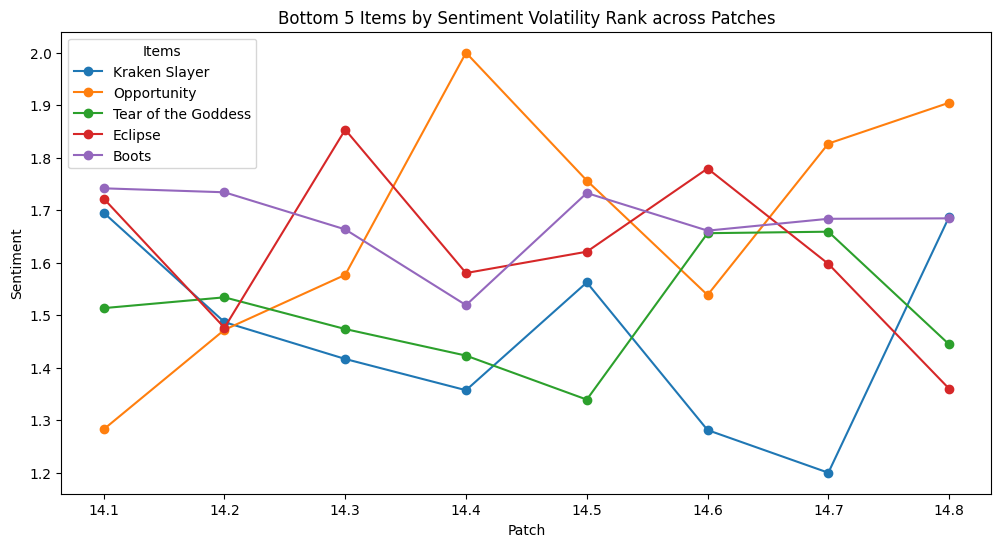

In [18]:
term_patch_values_df = post_contents_df.groupby(['Item', 'Patch']).agg(
    Score=('Score', 'mean'),
    BERT_BASE_Title_Sentiment=('BERT-BASE Title Sentiment', 'mean'),
    RoBERTa_Title_Sentiment=('RoBERTa Title Sentiment', 'mean'),
    BERT_BASE_Content_Sentiment=('BERT-BASE Content Sentiment', 'mean'),
    RoBERTa_Content_Sentiment=('RoBERTa Content Sentiment', 'mean'),
    Number_of_Posts=('ID', 'size')
).reset_index()
term_patch_values_df['Avg_Sentiment'] = (term_patch_values_df['BERT_BASE_Title_Sentiment'] + term_patch_values_df['RoBERTa_Title_Sentiment'] + term_patch_values_df['BERT_BASE_Content_Sentiment'] + term_patch_values_df['RoBERTa_Content_Sentiment']) / 4
term_patch_values_df = term_patch_values_df[term_patch_values_df['Item'] != 'Unknown Item']

term_patch_values_df['diffs'] = term_patch_values_df['Avg_Sentiment'].diff()
mask = term_patch_values_df.Item != term_patch_values_df.Item.shift(1)
term_patch_values_df.loc[mask, 'diffs'] = np.nan
term_patch_values_df['diffs'] = term_patch_values_df['diffs'].fillna(0)
term_patch_values_df['diffs_squared'] = term_patch_values_df['diffs'] ** 2

# Normalize
columns_to_normalize = ['diffs_squared']
term_patch_values_df[columns_to_normalize] = term_patch_values_df[columns_to_normalize].apply(lambda x: (x - x.mean()) / x.std())

volatility_df = term_patch_values_df.groupby(['Item']).agg(
    diffs_squared=('diffs_squared', 'mean'),
    Number_of_Posts=('Number_of_Posts', 'sum')
).reset_index()
volatility_df['volatility_rank'] = volatility_df['diffs_squared'] * volatility_df['Number_of_Posts']
volatility_df.sort_values(by='volatility_rank', ascending=False, inplace=True)
volatility_df.reset_index(drop=True, inplace=True)
volatility_df = volatility_df.iloc[-5:]
volatility_df.reset_index(drop=True, inplace=True)

plot_df = term_patch_values_df[term_patch_values_df['Item'].isin(volatility_df['Item'])]
plot_df = plot_df.merge(volatility_df[['Item', 'volatility_rank']], on='Item', how='left')
plot_df.sort_values(by=['volatility_rank', 'Patch'], ascending=False, inplace=True)

# Plotting
plt.figure(figsize=(12, 6))

for champ in plot_df['Item'].unique():
    subset = plot_df[plot_df['Item'] == champ]
    plt.plot(subset['Patch'], subset['Avg_Sentiment'], marker='o', label=champ)

plt.title('Bottom 5 Items by Sentiment Volatility Rank across Patches')
plt.xlabel('Patch')
plt.ylabel('Sentiment')
# plt.yticks([])
plt.legend(title='Items')
plt.grid(False)
plt.show()